# Соберем сверточную нейронную сеть LiNet5

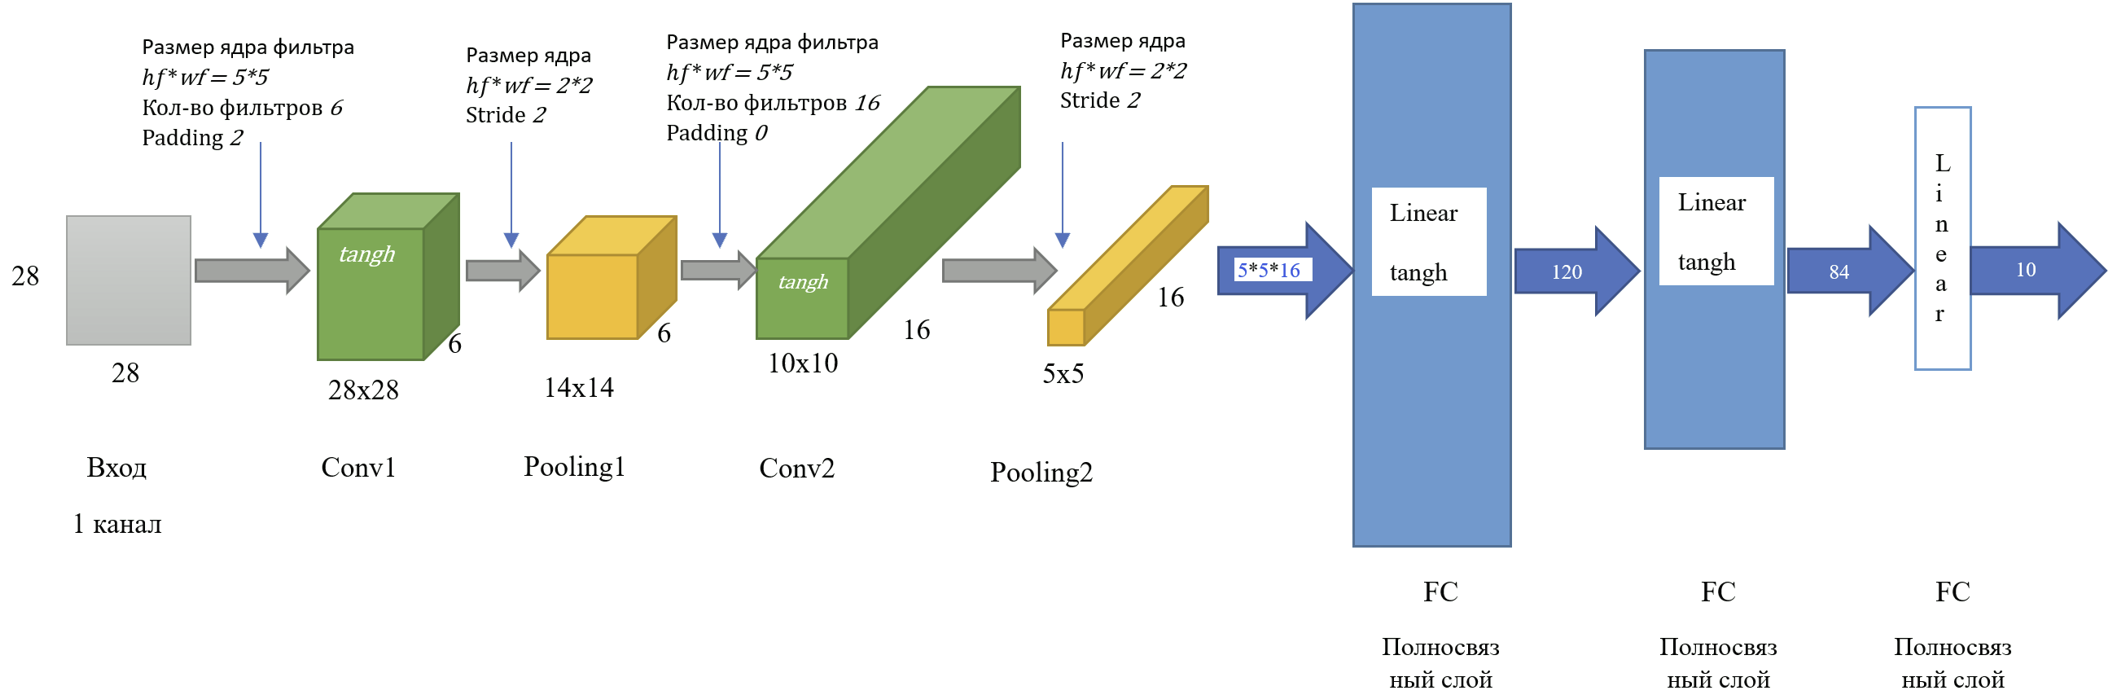


В архитектуре нейронной сети, показанной выше:

**Слой Conv1** представляет собой сверточный слой с шестью картами признаков, размер которых составляет 28 × 28, функция активации tangh;
**Слой Pooling1** – это слой подвыборки (polling) с шестью картами признаков, размер которых составляет 14 × 14, функция активации AvgPooling;
**Слой Conv2** представляет собой сверточный слой с шестнадцатью характеристическими картами (слоями), размер которых составляет 10 × 10, функция активации tangh;
**Слой Pooling2** является слоем подвыборки с шестнадцатью характеристическими картами, размер которых составляет 5 × 5, функция активации AvgPooling;
**Слой FC** представляет собой полносвязанный слой, вход 5*5*16 нейронов (признаков), выход 120 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 120 нейронов (признаков), выход 84 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 84 нейронов (признаков), выход 10 нейронов;



In [1]:
!pip install torch

In [2]:
!pip install torchvision

In [3]:
# импортируем библиотеки

import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
import torchvision.datasets

# загружаем сразу в трайн и тест
train = torchvision.datasets.FashionMNIST('./', download=True, train=True)
test = torchvision.datasets.FashionMNIST('./', download=True, train=False)

In [5]:
# формируем датасеты для обучения, тестирования, целевые переменные
X_train = train.train_data
y_train = train.train_labels
X_test = test.test_data
y_test = test.test_labels

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


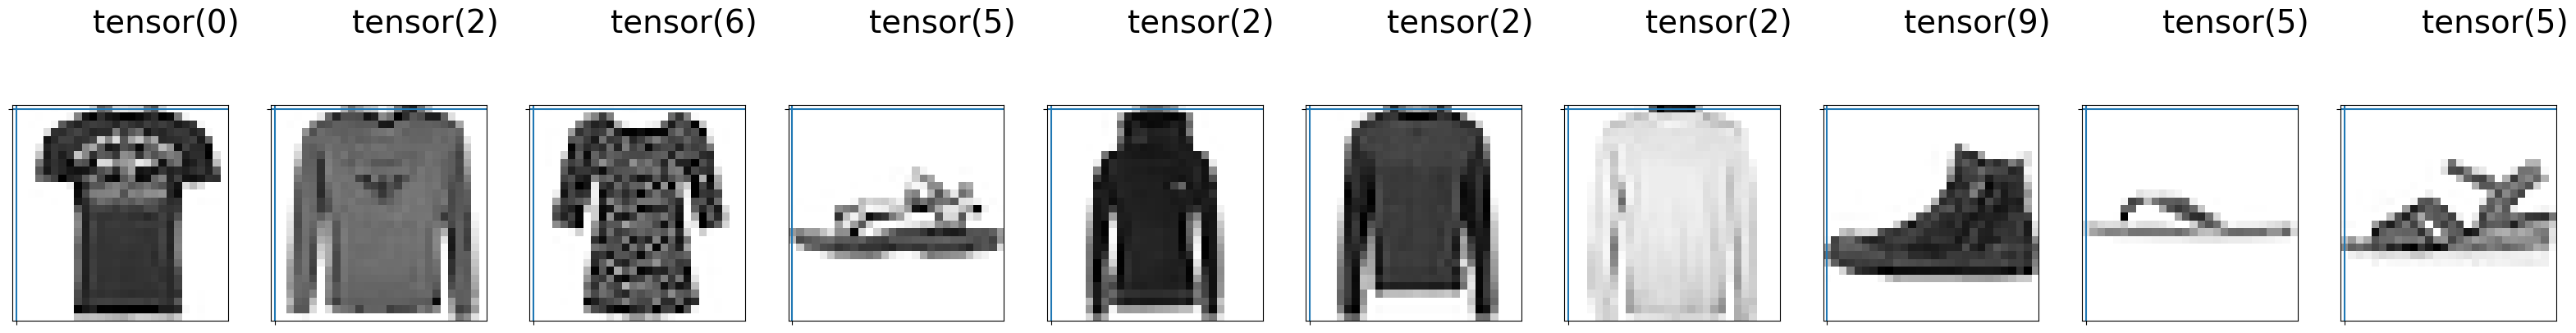

In [6]:
# посмотрим, что пришло

import numpy as np
import matplotlib.pyplot as plt

# посмотрим какие-то произвольные изображения из датасета
count = 0
sample_size = 10  # сколько картинок будем смотреть
plt.figure(figsize=(40, 20))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=28)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [7]:
# сколько изображений в трейне и тесте
len(y_train), len(y_test)

(60000, 10000)

image:
tensor([[  0,   0,   0,   0,   0,   0,   0,  11, 142, 200, 106,   0,   0,   0,
           0,   0,   0,   0,  85, 185, 112,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 152, 214, 217, 194, 236, 216, 187, 149,
         135, 153, 211, 217, 231, 205, 217, 188,  34,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  66, 185, 166, 180, 181, 190, 211, 221, 197,
         146, 198, 206, 191, 168, 190, 172, 188, 175,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 135, 153, 160, 175, 180, 170, 186, 187, 190,
         188, 190, 187, 174, 195, 185, 174, 161, 175,  59,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 161, 147, 160, 170, 178, 177, 180, 168, 173,
         174, 171, 185, 184, 185, 172, 171, 164, 174, 120,   0,   0,   0,   0],
        [  0,   0,   0,   0,   2, 175, 146, 145, 168, 178, 181, 185, 180, 184,
         178, 179, 187, 191, 193, 190, 181, 171, 172, 158,   0,   0,   0,   0],
        [  0,   0,   0,   0,  35, 177, 

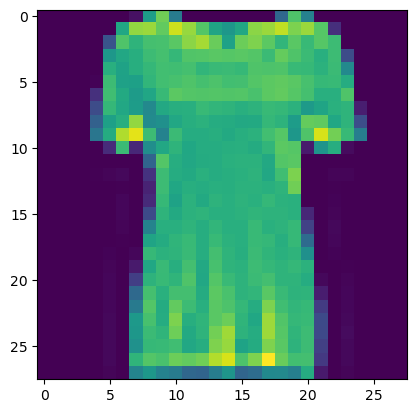

tensor(0)


In [8]:
# нарисуем, c чем мы имеем дело
import matplotlib.pyplot as plt

im_number = 10

# вот как хранятся изображения в компьютере
print(f"image:\n{X_train[im_number, :, :]}")

# а так их видим мы
plt.imshow(X_train[im_number, :, :])

plt.show()
print(y_train[im_number])

In [9]:
# посмотртим тип "картинок"
type(X_train[10, :, :])

torch.Tensor

In [10]:
X_train.shape

torch.Size([60000, 28, 28])

In [11]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [12]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [13]:
X_test.shape

torch.Size([10000, 1, 28, 28])

In [14]:
# Определяем класс, которые и будет представлять нашу нейронку
# какие слои - см описание вначале блокнота

class LeNet5(torch.nn.Module):
    # конструктор. Определям вообще какие слои у нас будут
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()

        self.fc3   = torch.nn.Linear(84, 10)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [15]:
device = "cpu"

# отправляем туда нашу нейронку
lenet5 = lenet5.to(device)

In [16]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [35]:
# будем оптимизировать по 100 параметров одним комплектом (бачем)
batch_size = 100

# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []


train_loss_history = []

# не забываем отправить все выборки на устройство, на котором обучаем
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # делаем предсказание
        preds = lenet5.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())


    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.8992000222206116 
epoch1 - accuracy test 0.8970000147819519 
epoch2 - accuracy test 0.8912000060081482 
epoch3 - accuracy test 0.9035999774932861 
epoch4 - accuracy test 0.9035999774932861 
epoch5 - accuracy test 0.9003000259399414 
epoch6 - accuracy test 0.9038000106811523 
epoch7 - accuracy test 0.8899999856948853 
epoch8 - accuracy test 0.900600016117096 
epoch9 - accuracy test 0.8934999704360962 
epoch10 - accuracy test 0.9024999737739563 
epoch11 - accuracy test 0.8998000025749207 
epoch12 - accuracy test 0.8939999938011169 
epoch13 - accuracy test 0.9046000242233276 
epoch14 - accuracy test 0.8970000147819519 
epoch15 - accuracy test 0.901199996471405 
epoch16 - accuracy test 0.9002000093460083 
epoch17 - accuracy test 0.8985999822616577 
epoch18 - accuracy test 0.8978000283241272 
epoch19 - accuracy test 0.9021000266075134 
epoch20 - accuracy test 0.8978999853134155 
epoch21 - accuracy test 0.8948000073432922 
epoch22 - accuracy test 0.8981999754905701 


C:\Users\yasur\AppData\Local\Temp\ipykernel_6492\3964124045.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


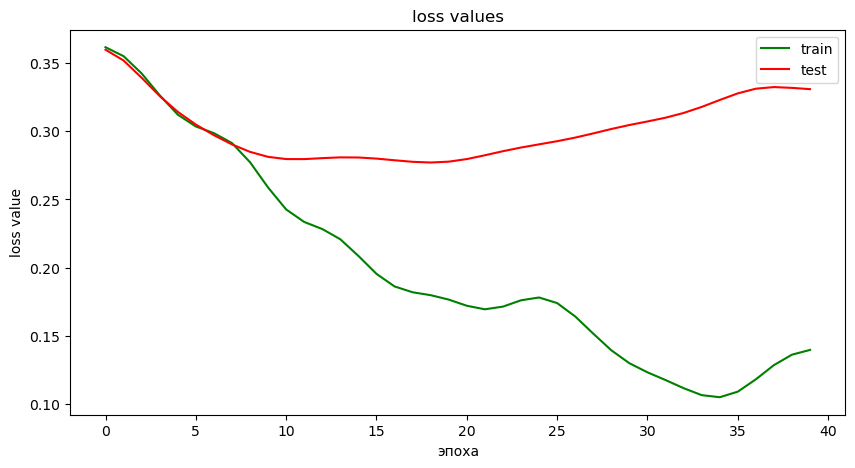

In [18]:
# строим графики - функции потерь

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()

C:\Users\yasur\AppData\Local\Temp\ipykernel_6492\2679742005.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


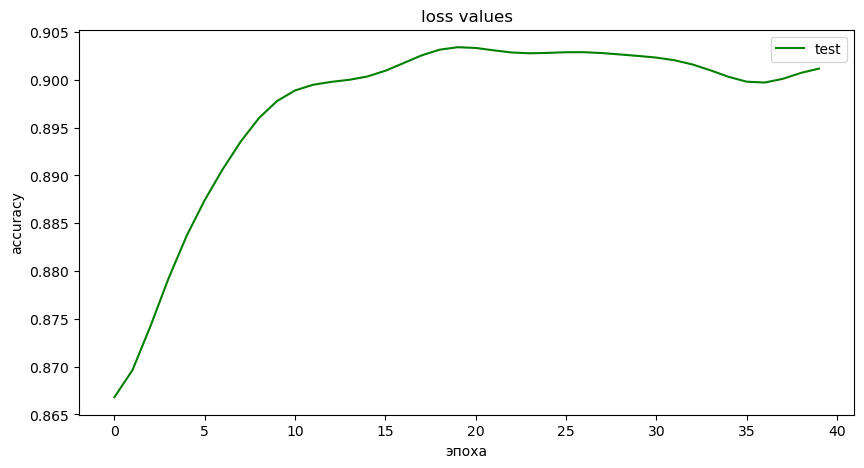

In [19]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

In [42]:
# сохраняем произвольное число из датасета (тензор) в файл
timg = X_train[0]

torch.save(timg,'tensor.pt')

In [43]:
# смотрим размер тензора - изображения
timg.size()

torch.Size([1, 28, 28])

In [22]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

X_test.size()

# то есть нам нужен тензор размера [1,1,28,28]

torch.Size([10000, 1, 28, 28])

In [23]:
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)


In [24]:
# вот так сохраняют модель с помощью pickle
import pickle

with open("model.pickle", "wb") as pickle_file:
    pickle.dump(lenet5, pickle_file)



In [44]:
# считываем модель, сохраненную в dill
import torch
import torch.nn as nn
#from LeNET_5 import LeNet
import pandas as pd
import numpy as np

ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


C:\Users\yasur\AppData\Local\Temp\ipykernel_6492\681362685.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


In [40]:
# смотрим тип модели
type(modelp)

__main__.LeNet5

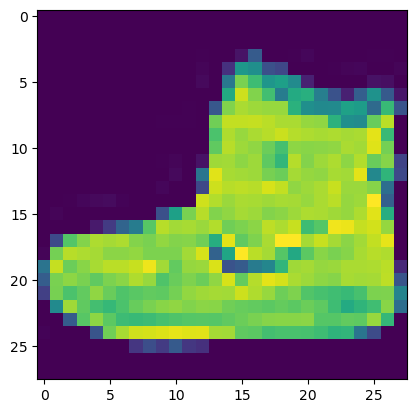

In [45]:
# смотрим, что за цифру считали
plt.imshow(test_data[0, :, :])
plt.show()

In [28]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

C:\Users\yasur\AppData\Local\Temp\ipykernel_6492\3192455546.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  t_data = torch.tensor([test_data.numpy()])


In [29]:
# проверяем
t_data.shape

torch.Size([1, 1, 28, 28])

In [30]:
# проверяем, на чем можем считать
dev = torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [31]:
# делаем предсказание
preds = modelp.forward(t_data)

In [32]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[-3.4862,  2.9645, -4.3874, -1.9206,  1.6746, -0.3618, -3.6973,  8.4344,
          0.1518, 15.2450]], grad_fn=<AddmmBackward0>)


In [33]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [37]:
# Словарь для сопоставления цифры с названием класса
labels_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [38]:
# Выводим предсказанные классы с их названиями
for pred in prediction:
    print(f"Prediction: {pred}, Label: {labels_dict.get(pred, 'Unknown class')}")

Prediction: 9, Label: Ankle boot


Ботинок предсказан верно.